# Visualising rhyme networks in the music of Du Chemin

## What are we doing?

We will create a network visualisation that shows rhyme words that are used together in a corpus of music by  Nicolas Du Chemin. You can read more about the larger project from which the data is drawn here: http://digitalduchemin.org

When constructing a network visualisation, we are concerned primarily with two constructs: **nodes** and **edges**. In this instance, the **nodes** are individual rhyme words, while the **edges** indicate that these words appear as rhymes for one another at least once. For our current purposes, it is actually sufficient to construct *just* a list of edges, since the nodes can be derived from this.

In the image below, for instance, we can see the following edges (and many more). We are making no distinction here about the direction of the edge so these could also be reversed:

1. *souvenir* -> *finir*
2. *devenir* -> *parvenir*
3. *advenir* -> *souvenir*

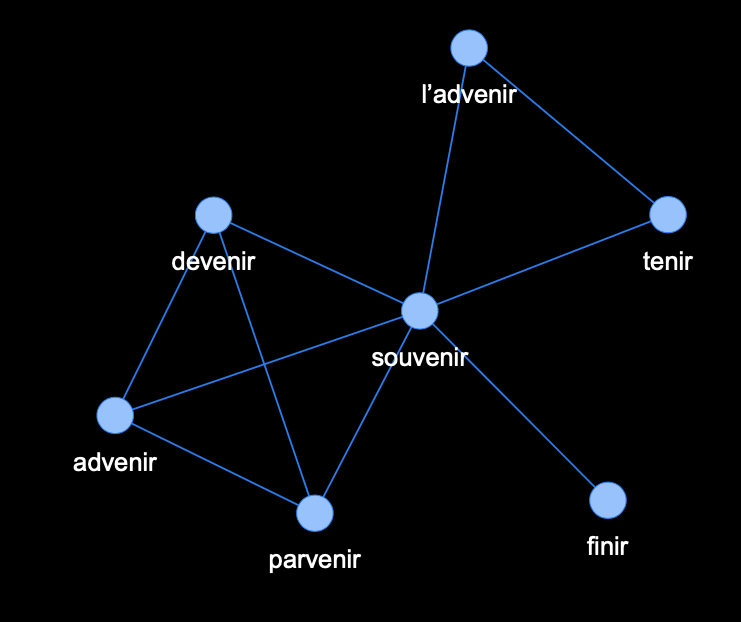

The finished network will be an interactive, zoomable HTML file that looks something like this:

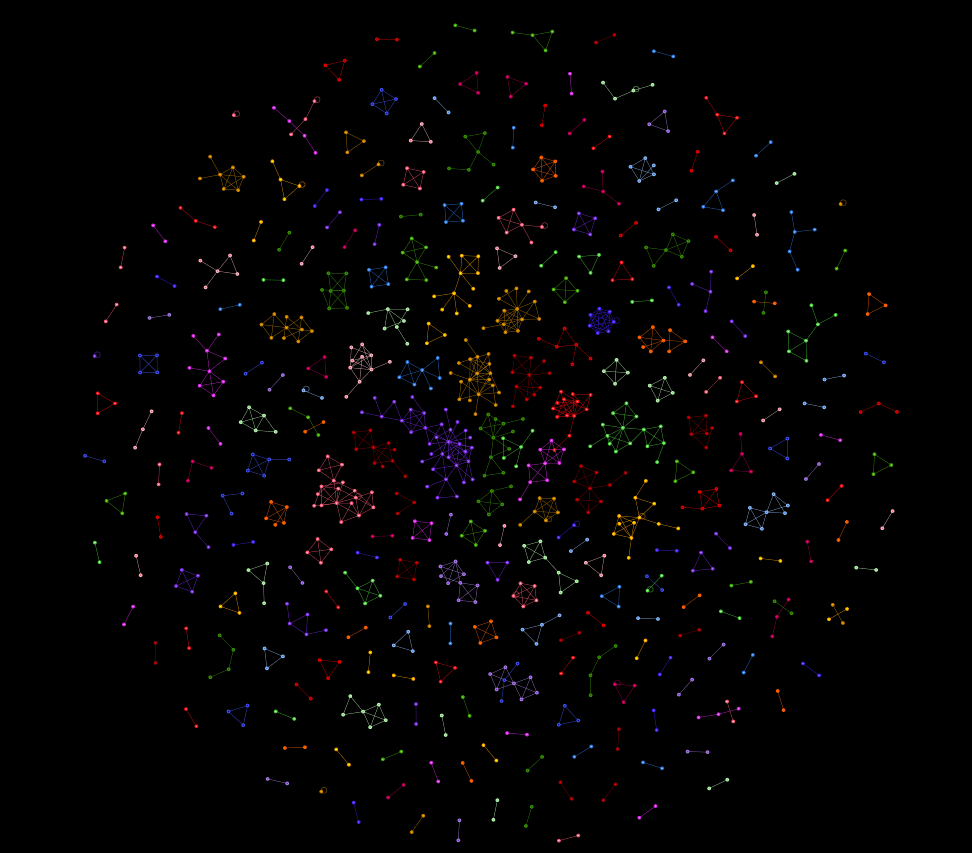

## What python packages do we need?

In [3]:
import pandas as pd
from pyvis.network import Network
from itertools import combinations
import networkx as nx
import re
from community import community_louvain
from copy import deepcopy

## How do we import the raw data?

In [25]:
FILEPATH = "https://raw.githubusercontent.com/RichardFreedman/DDL_2022_Pandas_Jupyter/main/data_files/DuChemin_Pieces_Phrases.csv"

In [34]:
duchemin = pd.read_csv(FILEPATH, usecols=lambda x: not x.startswith("Column")).dropna(subset=["Rhyme"])

Of the columns provided, we are mostly interested in:

- **PIECE ID:** A unique identifier for each piece
- **Text:** The music lyrics containing the rhyme word
- **Rhyme:** A letter indicating the rhyme. Words with the same letter in the same piece are rhyming. See below, for instance, *plaisir* and *desir*, which are both **"a"** rhymes.

In [45]:
duchemin.head(8)

PIECE ID  PHRASE ID  Phrase Start  Phrase Stop  \
0   DC0101        1.0           NaN          NaN   
1   DC0101        2.0           NaN          NaN   
2   DC0101        3.0           NaN          NaN   
3   DC0101        4.0           NaN          NaN   
4   DC0101        5.0           NaN          NaN   
5   DC0101        6.0           NaN          NaN   
6   DC0101        7.0           NaN          NaN   
7   DC0101        8.0           NaN          NaN   

                                      Text Rhyme      rhyme_word  
0      Qui souhaitez avoir tout le plaisir     a         plaisir  
1     Qu'un amy peult vouloir honnestement     b    honnestement  
2        Prenez exemple à mon chaste desir     a           desir  
3       Et vous mirez en mon contentement.     b    contentement  
4        Mais qui vouldroit audacieusement     b  audacieusement  
5     Voler au ciel, ou mon amour se tient     c           tient  
6        On luy diroit, aymez humainement.     b     humainement  
7  C'est au soleil que la lune appartient.     c      appartient

## Removing punctuation

If we look at just the text column, we notice that some lines of the poetic text end with punctuation. For our purposes, we want to isolate just the final word. To do this, we first create a function to remove punctuation:

In [36]:
def remove_non_alpha_chars(text):
    return re.sub("\W*$", "", text)

Next we apply this function to the text column and split on whitespace:

In [37]:
duchemin.Text.apply(remove_non_alpha_chars).str.split()

0             [Qui, souhaitez, avoir, tout, le, plaisir]
1             [Qu'un, amy, peult, vouloir, honnestement]
2               [Prenez, exemple, à, mon, chaste, desir]
3               [Et, vous, mirez, en, mon, contentement]
4                 [Mais, qui, vouldroit, audacieusement]
                              ...                       
2841         [Ou, me, mander, ton, plaisir,, &, vouloir]
2842        [Je, cesserois, à, me, plaindre, &, douloir]
2843    [Vivant, d'espoir,, qui, vrais, amant, supporte]
2844     [Mais, si, ton, cueur, me, met, à, non-chaloir]
2845         [Je, m'en, iray, mourir, devant, ta, porte]
Name: Text, Length: 1334, dtype: object

And finally, we take the last word from each line. This gives us a list of the *rhyme words*:

In [38]:
duchemin.Text.apply(remove_non_alpha_chars).str.split().str.get(-1)

0              plaisir
1         honnestement
2                desir
3         contentement
4       audacieusement
             ...      
2841           vouloir
2842           douloir
2843          supporte
2844       non-chaloir
2845             porte
Name: Text, Length: 1334, dtype: object

After testing that this all works above, we can create a new column to hold our rhyme words:

In [39]:
duchemin["rhyme_word"] = duchemin.Text.apply(remove_non_alpha_chars).str.split().str.get(-1)

In [40]:
duchemin

PIECE ID  PHRASE ID  Phrase Start  Phrase Stop  \
0      DC0101        1.0           NaN          NaN   
1      DC0101        2.0           NaN          NaN   
2      DC0101        3.0           NaN          NaN   
3      DC0101        4.0           NaN          NaN   
4      DC0101        5.0           NaN          NaN   
...       ...        ...           ...          ...   
2841   DC1414        6.0           NaN          NaN   
2842   DC1414        7.0           NaN          NaN   
2843   DC1414        8.0           NaN          NaN   
2844   DC1414        9.0           NaN          NaN   
2845   DC1414       10.0           NaN          NaN   

                                            Text Rhyme      rhyme_word  
0            Qui souhaitez avoir tout le plaisir     a         plaisir  
1           Qu'un amy peult vouloir honnestement     b    honnestement  
2              Prenez exemple à mon chaste desir     a           desir  
3             Et vous mirez en mon contentement.     b    contentement  
4              Mais qui vouldroit audacieusement     b  audacieusement  
...                                          ...   ...             ...  
2841        Ou me mander ton plaisir, & vouloir,     c         vouloir  
2842       Je cesserois à me plaindre & douloir,     c         douloir  
2843  Vivant d'espoir, qui vrais amant supporte:     d        supporte  
2844     Mais si ton cueur me met à non-chaloir,     c     non-chaloir  
2845        Je m'en iray mourir devant ta porte.     d           porte  

[1334 rows x 7 columns]

The next step is to get a list of words used for each rhyme, for each piece:

In [41]:
rhymes = duchemin.groupby(["PIECE ID", "Rhyme"]).rhyme_word.apply(list).reset_index()

Recall at the start we noted that *plaisir* and *desir* are both **"a"** rhymes in the first piece. Now we have them listed on their own row, and likewise for other rhymes:

In [42]:
rhymes

PIECE ID Rhyme                                         rhyme_word
0     DC0101     a                                   [plaisir, desir]
1     DC0101     b  [honnestement, contentement, audacieusement, h...
2     DC0101     c                                [tient, appartient]
3     DC0102     a                                [plaist, desplaist]
4     DC0102     b                             [marchander, demander]
..       ...   ...                                                ...
538   DC1313     c                                [diray, resjouiray]
539   DC1414     a                                   [secours, jours]
540   DC1414     b                        [souspire, rire, m'escrire]
541   DC1414     c                    [vouloir, douloir, non-chaloir]
542   DC1414     d                                  [supporte, porte]

[543 rows x 3 columns]

To complete our network, we want to create an edge between every pair of words sharing both a rhyme letter and a piece ID. Python has a useful `combinations` function that can help us get this done:

In [46]:
rhyme_pairs = rhymes.rhyme_word.apply(lambda x: list(combinations(x, 2)))

The result of this operation is a list of rhyme word pairs that will become the **edges** for our network visualisation:

In [47]:
rhyme_pairs.iloc[1]

[('honnestement', 'contentement'),
 ('honnestement', 'audacieusement'),
 ('honnestement', 'humainement'),
 ('contentement', 'audacieusement'),
 ('contentement', 'humainement'),
 ('audacieusement', 'humainement')]

The final step in preparing our edges is to remove duplicates:

In [19]:
unique_rhyme_pairs = rhyme_pairs.explode().dropna().unique()
unique_rhyme_pairs

array([('plaisir', 'desir'), ('honnestement', 'contentement'),
       ('honnestement', 'audacieusement'), ...,
       ('vouloir', 'non-chaloir'), ('douloir', 'non-chaloir'),
       ('supporte', 'porte')], dtype=object)

## Adding communities

You might have noticed in the example at the top of this page that all words in a given rhyming cluster share a colour. This makes it easier to visually distinguish the groups. We use an existing python package to help us with this, assigning a group to each node. You can read more about it here: https://github.com/taynaud/python-louvain

After running the two cells below we will have created our network. 

In [21]:
def add_communities(G):
    G = deepcopy(G)
    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, "group")
    return G

In [22]:
G = nx.Graph()
G.add_edges_from(unique_rhyme_pairs)
G = add_communities(G)

## Visualising the network

Next, we have to prepare our network for visualisation. Note that we can specify here things such as a font colour, background colour, height and width:

In [23]:
pyvis_graph = Network(notebook=False, width="1600px", height="900px", bgcolor="black", font_color="white")

In [24]:
pyvis_graph.from_nx(G)

Finally, we can save our network to an HTML file. Once this is done, try opening the *rhymes.html* file in your web browser. It may take a few moments to load.

In [20]:
pyvis_graph.show("rhymes.html")

## Questions

1. In this example, we removed duplicate edges to simplify the network. How else could we have shown these?
2. All of the nodes in our network are the same size, what other dimensions of the data could we show by varying the size of the nodes?
3. We used an existing algorithm to identify *communities* and colour clusters within the network. Can you think of other ways we could have used colour instead?